In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "xxxx"
os.environ["LANGCHAIN_PROJECT"] = "agent-book"

os.environ["OPENAI_API_KEY"] = "xxxx"

os.environ["TAVILY_API_KEY"] = "xxxx"

os.environ["COHERE_API_KEY"] = "xxxx"

In [5]:
!pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22 pydantic==2.10.6

  Using cached langchain-0.3.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached langchain_openai-0.2.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_text_splitters-0.3.8-py3-none-any.whl.metadata (1.9 kB)
  Using cached langsmith-0.1.147-py3-none-any.whl.metadata (14 kB)
INFO: pip is looking at multiple versions of langchain-core to determine which version is compatible with other requirements. This could take a while.
  Using cached langchain_core-0.3.66-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_core-0.3.65-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_core-0.3.64-py3-none-any.whl.metadata (5.8 kB)
  Using cached langchain_core-0.3.63-py3-none-any.whl.metadata (5.8 kB)
Using cached langchain-0.3.0-py3-none-any.whl (1.0 MB)
Using cached langchain_openai-0.2.0-py3-none-any.whl (51 kB)
Using cached langchain_core-0.3.63-py3-none-any.whl (438 kB)
Using cached langchain_text_splitters-0.3.8-py3-none-any.whl (32 kB)
Using cached langsmith-0.1.1

## ロールの定義

In [6]:
ROLES = {
    "1": {
        "name": "一般知識エキスパート",
        "description": "幅広い分野の一般的な質問に答える",
        "details": "幅広い分野の一般的な質問に対して、正確で分かりやすい回答を提供してください。"
    },
    "2": {
        "name": "生成AI製品エキスパート",
        "description": "生成AIや関連製品、技術に関する専門的な質問に答える",
        "details": "生成AIや関連製品、技術に関する専門的な質問に対して、最新の情報と深い洞察を提供してください。"
    },
    "3": {
        "name": "カウンセラー",
        "description": "個人的な悩みや心理的な問題に対してサポートを提供する",
        "details": "個人的な悩みや心理的な問題に対して、共感的で支援的な回答を提供し、可能であれば適切なアドバイスも行ってください。"
    }
}

## ステートの定義

In [7]:
import operator
from typing import Annotated

from pydantic import BaseModel, Field


class State(BaseModel):
    query: str = Field(..., description="ユーザーからの質問")
    current_role: str = Field(
        default="", description="選定された回答ロール"
    )
    messages: Annotated[list[str], operator.add] = Field(
        default=[], description="回答履歴"
    )
    current_judge: bool = Field(
        default=False, description="品質チェックの結果"
    )
    judgement_reason: str = Field(
        default="", description="品質チェックの判定理由"
    )

## チャットモデルの初期化

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables import ConfigurableField

llm = ChatOpenAI(model="gpt-4o", temperature=0.0)
# 後からmax_tokensの値を変更できるように、変更可能なフィールドを宣言
llm = llm.configurable_fields(max_tokens=ConfigurableField(id='max_tokens'))

## ノードの定義

### selectionノード
回答ノードの選定を行う

In [9]:
from typing import Any

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def selection_node(state: State) -> dict[str, Any]:
    query = state.query
    role_options = "\n".join([f"{k}. {v['name']}: {v['description']}" for k, v in ROLES.items()])
    prompt = ChatPromptTemplate.from_template(
"""質問を分析し、最も適切な回答担当ロールを選択してください。

選択肢:
{role_options}

回答は選択肢の番号（1、2、または3）のみを返してください。

質問: {query}
""".strip()
    )
    # 選択肢の番号のみを返すことを期待したいため、max_tokensの値を1に変更
    chain = prompt | llm.with_config(configurable=dict(max_tokens=1)) | StrOutputParser()
    role_number = chain.invoke({"role_options": role_options, "query": query})

    selected_role = ROLES[role_number.strip()]["name"]
    return {"current_role": selected_role}

### answeringノード
ロールに基づいて回答を行う

In [10]:
def answering_node(state: State) -> dict[str, Any]:
    query = state.query
    role = state.current_role
    role_details = "\n".join([f"- {v['name']}: {v['details']}" for v in ROLES.values()])
    prompt = ChatPromptTemplate.from_template(
"""あなたは{role}として回答してください。以下の質問に対して、あなたの役割に基づいた適切な回答を提供してください。

役割の詳細:
{role_details}

質問: {query}

回答:""".strip()
    )
    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"role": role, "role_details": role_details, "query": query})
    return {"messages": [answer]}

### checkノード
回答の品質をチェックする

In [11]:
class Judgement(BaseModel):
    judge: bool = Field(default=False, description="判定結果")
    reason: str = Field(default="", description="判定理由")

def check_node(state: State) -> dict[str, Any]:
    query = state.query
    answer = state.messages[-1]
    prompt = ChatPromptTemplate.from_template(
"""以下の回答の品質をチェックし、問題がある場合は'False'、問題がない場合は'True'を回答してください。
また、その判断理由も説明してください。

ユーザーからの質問: {query}
回答: {answer}
""".strip()
    )
    chain = prompt | llm.with_structured_output(Judgement)
    result: Judgement = chain.invoke({"query": query, "answer": answer})

    return {
        "current_judge": result.judge,
        "judgement_reason": result.reason
    }

## グラフの作成

In [12]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

## ノードの追加

In [13]:
workflow.add_node("selection", selection_node)
workflow.add_node("answering", answering_node)
workflow.add_node("check", check_node)

## エッジの定義

In [14]:
# selectionノードから処理を開始
workflow.set_entry_point("selection")

# selectionノードからansweringノードへ
workflow.add_edge("selection", "answering")
# answeringノードからcheckノードへ
workflow.add_edge("answering", "check")

## 条件付きエッジの定義

In [15]:
from langgraph.graph import END

# checkノードから次のノードへの遷移に条件付きエッジを定義
# state.current_judgeの値がTrueならENDノードへ、Falseならselectionノードへ
workflow.add_conditional_edges(
    "check",
    lambda state: state.current_judge,
    {True: END, False: "selection"}
)

## グラフのコンパイル

In [16]:
compiled = workflow.compile()

## グラフの実行

In [17]:
initial_state = State(query="生成AIについて教えてください")
result = compiled.invoke(initial_state)

## 結果確認

In [18]:
result

{'query': '生成AIについて教えてください',
 'current_role': '生成AI製品エキスパート',
 'messages': ['生成AI製品エキスパートとしてお答えします。\n\n生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、動画などの生成が含まれます。生成AIの代表的な技術には、以下のようなものがあります。\n\n1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。\n\n2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。\n\n3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。\n\n生成AIは、クリエイティブな分野やエンターテインメント、教育、医療など、さまざまな分野で活用されています。例えば、広告やマーケティングのコンテンツ生成、教育用の教材作成、医療データの解析などに応用されています。\n\nこの技術は急速に進化しており、倫理的な課題やデータの偏りといった問題も議論されています。生成AIを活用する際には、これらの点にも注意を払うことが重要です。'],
 'current_judge': True,
 'judgement_reason': '回答は生成AIについての基本的な情報を網羅しており、自然言語処理、画像生成、音声合成といった具体的な技術例を挙げています。また、生成AIの応用分野や倫理的な課題についても触れており、全体としてバランスの取れた内容です。専門用語も適切に使用されており、一般的な理解を助ける内容となっています。'}

In [19]:
print(result["messages"][-1])

生成AI製品エキスパートとしてお答えします。

生成AI（生成的人工知能）は、データから新しいコンテンツを生成する能力を持つAI技術の一分野です。これには、テキスト、画像、音声、動画などの生成が含まれます。生成AIの代表的な技術には、以下のようなものがあります。

1. **自然言語処理（NLP）モデル**: 例えば、GPT（Generative Pre-trained Transformer）シリーズは、テキストの生成や翻訳、要約などに用いられます。これらのモデルは、大量のテキストデータを学習し、人間のように自然な文章を生成することができます。

2. **画像生成モデル**: GAN（Generative Adversarial Networks）やVAE（Variational Autoencoders）などの技術を用いて、新しい画像を生成します。これにより、アート作品の創作や、現実には存在しない人物の顔を生成することが可能です。

3. **音声合成**: TTS（Text-to-Speech）技術を用いて、テキストから自然な音声を生成します。これにより、音声アシスタントやナレーションの自動生成が可能になります。

生成AIは、クリエイティブな分野やエンターテインメント、教育、医療など、さまざまな分野で活用されています。例えば、広告やマーケティングのコンテンツ生成、教育用の教材作成、医療データの解析などに応用されています。

この技術は急速に進化しており、倫理的な課題やデータの偏りといった問題も議論されています。生成AIを活用する際には、これらの点にも注意を払うことが重要です。


## グラフ構造をビジュアライズ

In [ ]:
!apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp312-cp312-linux_x86_64.whl size=174115 sha256=94773de64eed736ec56d69a25b4f5fbb6b9207a17465c7ecb5df9eb674edf58d
  Stored in directory: /home/ubuntu/.cache/pip/wheels/e1/2f/c3/0f7719eda975973b474b79b98e1208e635565c1e4dac777ac8
Successfully built pygraphviz


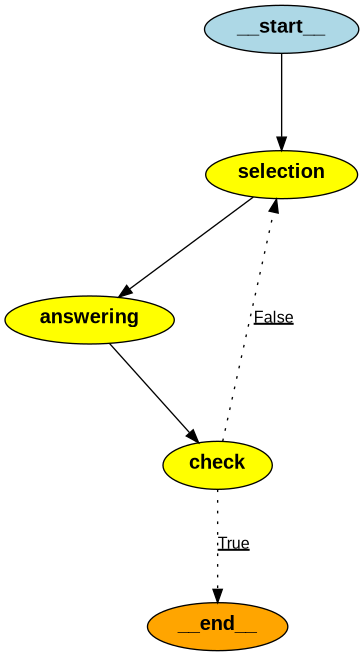

In [23]:
from IPython.display import Image

Image(compiled.get_graph().draw_png())

## チェックポイント

In [24]:
!pip install langgraph-checkpoint==1.0.11

  Attempting uninstall: langgraph-checkpoint
    Found existing installation: langgraph-checkpoint 1.0.12
    Uninstalling langgraph-checkpoint-1.0.12:
      Successfully uninstalled langgraph-checkpoint-1.0.12


In [25]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    additional_messages = []
    if not state.messages:
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))
    return {"messages": additional_messages}

# LLMからの応答を追加するノード関数
def llm_response(state: State) -> dict[str, Any]:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)
    ai_message = llm.invoke(state.messages)
    return {"messages": [ai_message]}

### チェックポイントの内容を表示する関数

In [27]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ:")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ:")
    pprint(checkpoint_tuple.metadata)

### グラフの定義とコンパイル

In [28]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")
graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

### 実行

In [29]:
config = {"configurable": {"thread_id": "example-1"}}
user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")
first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2e7b1ce-0c1c-416b-9fb7-ac227b17e5d3-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59})]}

### チェックポイントの変化を確認

In [30]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f058239-ef81-6fbd-8002-f6ac02a71591'}}, checkpoint={'v': 1, 'ts': '2025-07-03T15:37:26.264606+00:00', 'id': '1f058239-ef81-6fbd-8002-f6ac02a71591', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'log

In [31]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2e7b1ce-0c1c-416b-9fb7-ac227b17e5d3-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59})],
              

In [32]:
user_query = State(query="私の好物は何か覚えてる？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物は何か覚えてる？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2e7b1ce-0c1c-416b-9fb7-ac227b17e5d3-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59}),
  HumanMessage(content='私の好物は何か覚えてる？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅です。', additional_kwargs

In [33]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f05823d-8f6a-6166-8006-aade297c1fd3'}}, checkpoint={'v': 1, 'ts': '2025-07-03T15:39:03.562672+00:00', 'id': '1f05823d-8f6a-6166-8006-aade297c1fd3', 'channel_values': {'query': '私の好物は何か覚えてる？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': Non

In [34]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ:
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='わかりました！ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 48, 'total_tokens': 59, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2e7b1ce-0c1c-416b-9fb7-ac227b17e5d3-0', usage_metadata={'input_tokens': 48, 'output_tokens': 11, 'total_tokens': 59}),
               

### thred_idが異なるとステートは保存されていない
thred_id毎にステートが保存されている

In [35]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は何？")
other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は何？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は何？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 36, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--516facef-5348-46b1-99da-0ce0ccc50e22-0', usage_metadata={'input_tokens': 36, 'output_tokens': 14, 'total_tokens': 50})]}